In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('DataFiles/SMOTE_data.csv')
df.head()

,DTP,Ala,Cys,Asp,Glu,Phe,Gly,His,Ile,Lys,...,Trans_Helices_10,Trans_Helices_11,Trans_Helices_12,Trans_Helices_13,Trans_Helices_14,Trans_Helices_15,Trans_Helices_16,Trans_Helices_17,Trans_Helices_19,DTP.1
0,0,0.201217,0.049898,0.135014,0.192164,0.606348,0.082153,0.072733,0.316374,0.157088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.377079,0.074389,0.150936,0.184124,0.210396,0.157443,0.081300,0.219536,0.214624,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.179019,0.061000,0.206254,0.301967,0.258755,0.118346,0.183333,0.269995,0.192000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.217427,0.077897,0.210709,0.281810,0.316313,0.109911,0.072033,0.306474,0.182304,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.547961,0.061610,0.166653,0.203337,0.212984,0.195615,0.078567,0.121198,0.129280,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Split data
X = df.drop(['DTP'], axis=1)
y = df['DTP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert the training set and test set to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train.values).float()
X_test_tensor = torch.from_numpy(X_test.values).float()

# Convert the training set and test set to PyTorch datasets
train_dataset = TensorDataset(X_train_tensor)
test_dataset = TensorDataset(X_test_tensor)

# Create data loaders for the training set and test set
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [4]:

# class SAE3(nn.Module):
#     def __init__(self):
#         super(SAE3, self).__init__()

#         # Encoder layers
#         self.encoder_layers = nn.Sequential(
#             nn.Linear(282, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 36),
#             nn.ReLU(),
#             nn.Linear(36, 18),
#             nn.ReLU(),
#             nn.Linear(18, 9)
#         )
        
#         # Decoder layers
#         self.decoder_layers = nn.Sequential(
#             nn.Linear(9, 18),
#             nn.ReLU(),
#             nn.Linear(18, 36),
#             nn.ReLU(),
#             nn.Linear(36, 64),
#             nn.ReLU(),
#             nn.Linear(64, 128),
#             nn.ReLU(),
#             nn.Linear(128, 282),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.encoder_layers(x)
#         x = self.decoder_layers(x)
#         return x

In [4]:
class SAE3(nn.Module):
    def __init__(self):
        super(SAE3, self).__init__()

        # Encoder layers
        self.encoder_layers = nn.Sequential(
            nn.Linear(input_layer, hidden_1),
            nn.ReLU(),
            nn.Linear(hidden_1, hidden_2),
        )
        
        # Decoder layers
        self.decoder_layers = nn.Sequential(
            nn.Linear(hidden_2, hidden_1),
            nn.ReLU(),
            nn.Linear(hidden_1, input_layer),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder_layers(x)
        x = self.decoder_layers(x)
        return x

input_layer = 282
hidden_1 = 140
hidden_2 = 10




In [5]:
import torch.optim as optim

def train(model, train_dataloader, loss_fn, optimizer, num_epochs):
    model.train() # set the model to training mode

    # Loop over the number of epochs
    for epoch in range(num_epochs):
        epoch_loss = 0.0 # to keep track of the loss per epoch
        
        # Loop over the training dataloader
        for x, _ in train_dataloader:
            optimizer.zero_grad() # reset the gradients
            
            # Forward pass
            outputs = model(x)
            loss = loss_fn(outputs, x)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() # accumulate the loss for this epoch
        
        # Print the average loss for this epoch
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss/len(train_dataloader)))




In [6]:
train_losses = []
test_losses = []

def train_stacked_autoencoder(model, train_dataloader, test_dataloader, num_epochs):
    optimizer = torch.optim.Adadelta(model.parameters())
    loss_fn = nn.MSELoss()

    for epoch in range(num_epochs):
        for i, (x,) in enumerate(train_dataloader):
            # Pass the input through the model
            reconstruction = model(x)

            # Calculate the reconstruction loss
            reconstruction_loss = loss_fn(reconstruction, x)

            # Zero the gradients
            optimizer.zero_grad()

            # Perform backpropagation and optimization
            reconstruction_loss.backward()
            optimizer.step()

        # Evaluate the model on the test data
        test_loss = 0
        with torch.no_grad():
            for i, (x_test,) in enumerate(test_dataloader):
                # Pass the test input through the model
                test_reconstruction = model(x_test)

                # calculate the test reconstruction loss
                test_loss += loss_fn(test_reconstruction, x_test).item()
        test_loss /= len(test_dataloader)
        print("Epoch {}: Train Loss: {:.4f} Test Loss: {:.4f}".format(epoch+1, reconstruction_loss.item(), test_loss))
        train_losses.append(reconstruction_loss.item())
        test_losses.append(test_loss)

    

In [7]:
# import torch.optim as optim



# def train_stacked_autoencoder(model, train_dataloader, test_dataloader, num_epochs):
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.03)
#     scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # decrease learning rate by a factor of 0.1 every 5 epochs
#     loss_fn = nn.MSELoss()

#     for epoch in range(num_epochs):
#         scheduler.step()
#         for i, (x,) in enumerate(train_dataloader):
#             # Pass the input through the model
#             reconstruction = model(x)

#             # Calculate the reconstruction loss
#             reconstruction_loss = loss_fn(reconstruction, x)

#             # Zero the gradients
#             optimizer.zero_grad()

#             # Perform backpropagation and optimization
#             reconstruction_loss.backward()
#             optimizer.step()

#         # Evaluate the model on the test data
#         test_loss = 0
#         with torch.no_grad():
#             for i, (x_test,) in enumerate(test_dataloader):
#                 # Pass the test input through the model
#                 test_reconstruction = model(x_test)

#                 # calculate the test reconstruction loss
#                 test_loss += loss_fn(test_reconstruction, x_test).item()
#         test_loss /= len(test_dataloader)
#         print("Epoch {}: Train Loss: {:.4f} Test Loss: {:.4f}".format(epoch+1, reconstruction_loss.item(), test_loss))
#         train_losses.append(reconstruction_loss.item())
#         test_losses.append(test_loss)


In [7]:

num_epochs = 25

model = SAE3()
history = train_stacked_autoencoder(model, train_dataloader,test_dataloader, num_epochs)

Epoch 1: Train Loss: 0.0169 Test Loss: 0.0142
Epoch 2: Train Loss: 0.0137 Test Loss: 0.0141
Epoch 3: Train Loss: 0.0137 Test Loss: 0.0141
Epoch 4: Train Loss: 0.0119 Test Loss: 0.0141
Epoch 5: Train Loss: 0.0102 Test Loss: 0.0140
Epoch 6: Train Loss: 0.0180 Test Loss: 0.0141
Epoch 7: Train Loss: 0.0164 Test Loss: 0.0140
Epoch 8: Train Loss: 0.0165 Test Loss: 0.0138
Epoch 9: Train Loss: 0.0134 Test Loss: 0.0138
Epoch 10: Train Loss: 0.0143 Test Loss: 0.0138
Epoch 11: Train Loss: 0.0161 Test Loss: 0.0135
Epoch 12: Train Loss: 0.0151 Test Loss: 0.0134
Epoch 13: Train Loss: 0.0147 Test Loss: 0.0131
Epoch 14: Train Loss: 0.0084 Test Loss: 0.0129
Epoch 15: Train Loss: 0.0163 Test Loss: 0.0125
Epoch 16: Train Loss: 0.0127 Test Loss: 0.0123
Epoch 17: Train Loss: 0.0075 Test Loss: 0.0121
Epoch 18: Train Loss: 0.0126 Test Loss: 0.0119
Epoch 19: Train Loss: 0.0135 Test Loss: 0.0117
Epoch 20: Train Loss: 0.0127 Test Loss: 0.0115
Epoch 21: Train Loss: 0.0061 Test Loss: 0.0113
Epoch 22: Train Loss: 

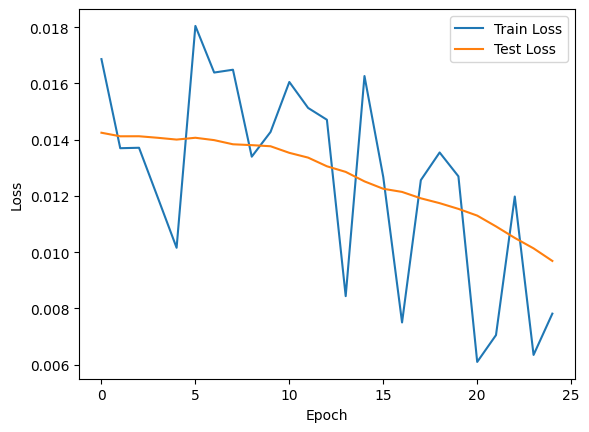

In [8]:
import matplotlib.pyplot as plt

plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
print(type(train_dataloader))
print(type(test_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [10]:
compressed_train_data = []
for i, x in enumerate(train_dataloader):
    x = x[0] # extract the tensor from the list
    x = x.view(x.size(0), -1)
    compressed_train = model.encoder_layers(x)
    compressed_train_data.append(compressed_train)

In [11]:
compressed_test_data = []
for i, x in enumerate(test_dataloader):
    x = x[0] # extract the tensor from the list
    x = x.view(x.size(0), -1)
    compressed_test = model.encoder_layers(x)
    compressed_test_data.append(compressed_test)

In [12]:
# print(compressed_train_data)

In [13]:
# print(compressed_test_data)

In [14]:
import xgboost as xgb
from xgboost import XGBClassifier

/Users/nick/opt/anaconda3/envs/Torch_SB2/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [15]:
compressed_train_data_np = [c.detach().numpy() for c in compressed_train_data]
compressed_train_data_np = np.concatenate(compressed_train_data_np)

In [16]:
compressed_test_data_np = [c.detach().numpy() for c in compressed_test_data]
compressed_test_data_np = np.concatenate(compressed_test_data_np)

In [17]:
xgb_model = XGBClassifier()
xgb_model.fit(compressed_train_data_np, y_train)

/Users/nick/opt/anaconda3/envs/Torch_SB2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:49:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
predictions = xgb_model.predict(compressed_test_data_np)

In [19]:
print(len(predictions))

3226


In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, predictions)

array([[804, 776],
       [816, 830]])

/Users/nick/opt/anaconda3/envs/Torch_SB2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


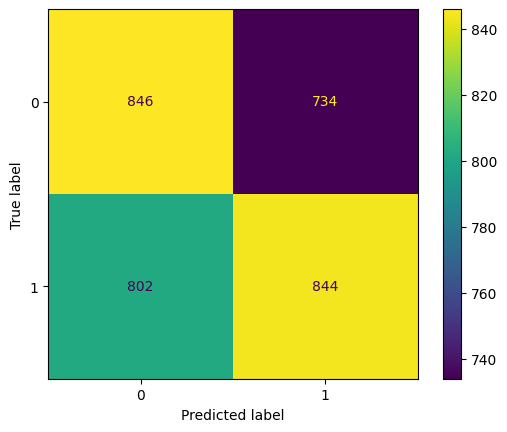

In [20]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(xgb_model, compressed_test_data_np, y_test)

In [30]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Set up the biased SVM with a linear kernel
biased_svm = SVC(kernel='linear', class_weight='balanced')

# Define the parameter grid to search
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

# Use GridSearchCV to find the best parameters for the SVM
grid = GridSearchCV(biased_svm, param_grid, verbose=3)
grid.fit(compressed_train_data_np, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters found: ",grid.best_params_)

# Use the best parameters to train the final model
final_model = SVC(kernel='linear', C=grid.best_params_['C'], gamma=grid.best_params_['gamma'], class_weight='balanced')
final_model.fit(compressed_train_data_np, y_train)

# Use the final model to make predictions on the test data
predictions = final_model.predict(compressed_test_data_np)

# Evaluate the model's performance on the test data
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ....................C=0.1, gamma=1;, score=0.497 total time=   1.8s
[CV 2/5] END ....................C=0.1, gamma=1;, score=0.494 total time=   1.7s
[CV 3/5] END ....................C=0.1, gamma=1;, score=0.502 total time=   1.8s
[CV 4/5] END ....................C=0.1, gamma=1;, score=0.506 total time=   1.6s
[CV 5/5] END ....................C=0.1, gamma=1;, score=0.498 total time=   1.7s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=0.497 total time=   1.7s
[CV 2/5] END ..................C=0.1, gamma=0.1;, score=0.494 total time=   1.6s
[CV 3/5] END ..................C=0.1, gamma=0.1;, score=0.502 total time=   1.8s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=0.506 total time=   1.6s
[CV 5/5] END ..................C=0.1, gamma=0.1;, score=0.498 total time=   1.6s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.497 total time=   1.7s
[CV 2/5] END .................C=0.1, gamma=0.01

In [31]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Set up the biased SVM with a linear kernel
biased_svm = SVC(kernel='sigmoid', class_weight='balanced')

# Define the parameter grid to search
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

# Use GridSearchCV to find the best parameters for the SVM
grid = GridSearchCV(biased_svm, param_grid, verbose=3)
grid.fit(compressed_train_data_np, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters found: ",grid.best_params_)

# Use the best parameters to train the final model
final_model = SVC(kernel='sigmoid', C=grid.best_params_['C'], gamma=grid.best_params_['gamma'], class_weight='balanced')
final_model.fit(compressed_train_data_np, y_train)

# Use the final model to make predictions on the test data
predictions = final_model.predict(compressed_test_data_np)

# Evaluate the model's performance on the test data
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ....................C=0.1, gamma=1;, score=0.501 total time=   1.7s
[CV 2/5] END ....................C=0.1, gamma=1;, score=0.515 total time=   1.3s
[CV 3/5] END ....................C=0.1, gamma=1;, score=0.504 total time=   1.3s
[CV 4/5] END ....................C=0.1, gamma=1;, score=0.490 total time=   1.3s
[CV 5/5] END ....................C=0.1, gamma=1;, score=0.528 total time=   1.4s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=0.493 total time=   2.4s
[CV 2/5] END ..................C=0.1, gamma=0.1;, score=0.498 total time=   2.0s
[CV 3/5] END ..................C=0.1, gamma=0.1;, score=0.514 total time=   1.8s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=0.498 total time=   1.8s
[CV 5/5] END ..................C=0.1, gamma=0.1;, score=0.526 total time=   1.7s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.512 total time=   1.3s
[CV 2/5] END .................C=0.1, gamma=0.01

In [32]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Set up the biased SVM with a linear kernel
biased_svm = SVC(kernel='rbf', class_weight='balanced')

# Define the parameter grid to search
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

# Use GridSearchCV to find the best parameters for the SVM
grid = GridSearchCV(biased_svm, param_grid, verbose=3)
grid.fit(compressed_train_data_np, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters found: ",grid.best_params_)

# Use the best parameters to train the final model
final_model = SVC(kernel='rbf', C=grid.best_params_['C'], gamma=grid.best_params_['gamma'], class_weight='balanced')
final_model.fit(compressed_train_data_np, y_train)

# Use the final model to make predictions on the test data
predictions = final_model.predict(compressed_test_data_np)

# Evaluate the model's performance on the test data
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ....................C=0.1, gamma=1;, score=0.499 total time=   2.9s
[CV 2/5] END ....................C=0.1, gamma=1;, score=0.496 total time=   2.9s
[CV 3/5] END ....................C=0.1, gamma=1;, score=0.519 total time=   2.9s
[CV 4/5] END ....................C=0.1, gamma=1;, score=0.505 total time=   2.8s
[CV 5/5] END ....................C=0.1, gamma=1;, score=0.508 total time=   3.0s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=0.493 total time=   2.7s
[CV 2/5] END ..................C=0.1, gamma=0.1;, score=0.490 total time=   2.6s
[CV 3/5] END ..................C=0.1, gamma=0.1;, score=0.497 total time=   2.9s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=0.509 total time=   2.7s
[CV 5/5] END ..................C=0.1, gamma=0.1;, score=0.505 total time=   2.6s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.501 total time=   2.6s
[CV 2/5] END .................C=0.1, gamma=0.01

In [33]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Set up the biased SVM with a linear kernel
biased_svm = SVC(kernel='poly', class_weight='balanced')

# Define the parameter grid to search
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

# Use GridSearchCV to find the best parameters for the SVM
grid = GridSearchCV(biased_svm, param_grid, verbose=3)
grid.fit(compressed_train_data_np, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters found: ",grid.best_params_)

# Use the best parameters to train the final model
final_model = SVC(kernel='poly', C=grid.best_params_['C'], gamma=grid.best_params_['gamma'], class_weight='balanced')
final_model.fit(compressed_train_data_np, y_train)

# Use the final model to make predictions on the test data
predictions = final_model.predict(compressed_test_data_np)

# Evaluate the model's performance on the test data
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
